In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import string, os, random, cv2
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Embedding, LSTM

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
########### TASK 1 ############

In [14]:
#Вирішіть завдання класифікації даних за допомогою повнозв’язаної нейромережі прямого поширення

In [5]:
# Завантаження + підготовка числових ознак 
dataset = pd.read_csv('googleplaystore.csv')

# Перетворюємо всі колонки в числові
dataset['Reviews'] = pd.to_numeric(dataset['Reviews'], errors='coerce')
dataset['Rating'] = pd.to_numeric(dataset['Rating'], errors='coerce')

# Size — прибираємо 'M', 'k', 'Varies with device'
dataset['Size'] = dataset['Size'].replace('Varies with device', np.nan)
dataset['Size'] = dataset['Size'].str.replace('M', 'e6').str.replace('k', 'e3')
dataset['Size'] = pd.to_numeric(dataset['Size'], errors='coerce')

# Installs — прибираємо '+' і ','
dataset['Installs'] = dataset['Installs'].str.replace('[+,]', '', regex=True)
dataset['Installs'] = pd.to_numeric(dataset['Installs'], errors='coerce')

# Price — прибираємо '$'
dataset['Price'] = dataset['Price'].str.replace('$', '', regex=True)
dataset['Price'] = pd.to_numeric(dataset['Price'], errors='coerce')

# Заповнюємо пропуски медіаною (як у diabetes)
dataset_numeric = dataset[['Rating', 'Reviews', 'Size', 'Installs', 'Price']].fillna(dataset[['Rating', 'Reviews', 'Size', 'Installs', 'Price']].median())

# Це наш X — тільки числові ознаки
X = dataset_numeric
y = dataset['Category']  # це наш "Outcome"

print("X готово:", X.shape)
X.head()

X готово: (10841, 5)


,Rating,Reviews,Size,Installs,Price
0,4.1,159.0,19000000.0,10000.0,0.0
1,3.9,967.0,14000000.0,500000.0,0.0
2,4.7,87510.0,8700000.0,5000000.0,0.0
3,4.5,215644.0,25000000.0,50000000.0,0.0
4,4.3,967.0,2800000.0,100000.0,0.0


In [6]:
dataset.shape

(10841, 13)

In [7]:
X = dataset.drop('Category', axis=1)
y = dataset['Category']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=12345
)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.utils import class_weight # Додано для обробки дисбалансу класів

# -------------------------
# ПІДГОТОВКА ДАНИХ (Як у вас)
# -------------------------

drop_cols = ['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
# dataset припускається вже завантаженим
dataset = dataset.drop(columns=drop_cols, errors='ignore')

def convert_size(x):
    if isinstance(x, str):
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        if 'k' in x:
            return float(x.replace('k', '')) * 1_000
        if x == "Varies with device":
            return np.nan
    return np.nan

dataset["Size"] = dataset["Size"].apply(convert_size)

# Обробка числових стовпців
dataset["Price"] = dataset["Price"].replace('[\$,]', '', regex=True).astype(float)
dataset["Installs"] = dataset["Installs"].replace('[\+,]', '', regex=True).astype(float)
dataset["Reviews"] = pd.to_numeric(dataset["Reviews"], errors='coerce')

# Заповнення пропусків
dataset = dataset.fillna(0)

# Розділення на ознаки (X) та цільову змінну (y)
X = dataset.drop("Category", axis=1)

# Кодування цільової змінної та one-hot кодування
encoder = LabelEncoder()
y_labels = encoder.fit_transform(dataset["Category"]) # Зберігаємо для розрахунку ваг
number_classes = len(encoder.classes_) # number_classes = 34
y = keras.utils.to_categorical(y_labels, number_classes) # y для навчання

# Масштабування
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# ---------------------------------------------
# ОБРОБКА ДИСБАЛАНСУ КЛАСІВ (Ключовий крок)
# ---------------------------------------------
# Розрахунок ваг класів для збалансування навчання (враховуючи, що 22% занадто мало)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
# Перетворення масиву ваг у словник, необхідний для Keras
class_weights_dict = dict(enumerate(class_weights))


# -------------------------
# НЕЙРОМЕРЕЖА (Оптимізована архітектура)
# -------------------------
# Видалено повторне визначення моделі та неправильне використання loss="binary_crossentropy"
# Створена глибша модель для кращого вивчення залежностей у багатокласовій задачі

model = keras.Sequential([
    # Input layer. X.shape[1] = кількість ознак, що залишилися.
    keras.layers.Dense(256, input_shape=(X.shape[1],), activation='relu'),
    keras.layers.Dropout(0.3),
    # Додано більше нейронів та додатковий шар для кращої спроможності
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    # Вихідний шар має відповідати кількості класів (34)
    keras.layers.Dense(number_classes, activation='softmax') 
])

# -------------------------
# КОМПІЛЯЦІЯ ТА НАВЧАННЯ (Виправлено)
# -------------------------

model.compile(
    # Використовуємо коректну функцію втрат для багатокласової класифікації з one-hot кодуванням
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

# Збільшено кількість епох і додано class_weight для кращого результату
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, # Збільшено епохи для кращої збіжності з новими вагами
    batch_size=32,
    class_weight=class_weights_dict # Застосування ваг класів для вирішення проблеми 22% точності
)

# Видалено другий зайвий блок model.compile/model.fit

<>:29: SyntaxWarning: invalid escape sequence '\$'
<>:30: SyntaxWarning: invalid escape sequence '\+'
<>:29: SyntaxWarning: invalid escape sequence '\$'
<>:30: SyntaxWarning: invalid escape sequence '\+'
C:\Users\Dmytrik\AppData\Local\Temp\ipykernel_18416\509711608.py:29: SyntaxWarning: invalid escape sequence '\$'
  dataset["Price"] = dataset["Price"].replace('[\$,]', '', regex=True).astype(float)
C:\Users\Dmytrik\AppData\Local\Temp\ipykernel_18416\509711608.py:30: SyntaxWarning: invalid escape sequence '\+'
  dataset["Installs"] = dataset["Installs"].replace('[\+,]', '', regex=True).astype(float)
C:\Users\Dmytrik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regula

Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0724 - loss: 7.2692 - val_accuracy: 0.0678 - val_loss: 3.3395
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0795 - loss: 4.5117 - val_accuracy: 0.0964 - val_loss: 3.2727
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0830 - loss: 4.8962 - val_accuracy: 0.0899 - val_loss: 3.2792
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0876 - loss: 3.7643 - val_accuracy: 0.0848 - val_loss: 3.2957
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0936 - loss: 3.3755 - val_accuracy: 0.0899 - val_loss: 3.2867
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0962 - loss: 3.1430 - val_accuracy: 0.0816 - val_loss: 3.2827
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0977 - loss: 3.1048 - val_accuracy: 0.0917 - val_loss: 3.2510
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0919 - loss: 3.0612 - val_accu

In [45]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', results[0])
print('Accuracy:', results[1])

Losses: 3.2708771228790283
Accuracy: 0.08990318328142166


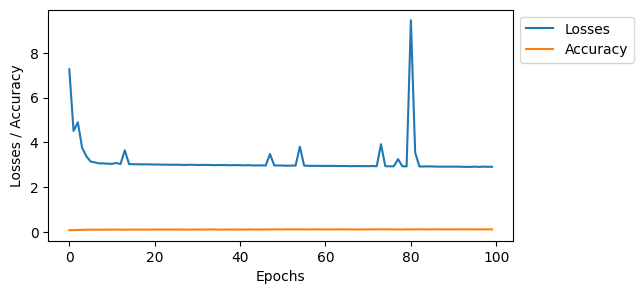

In [46]:
plt.figure(figsize=(6,3))

plt.plot(history.history['loss'])      
plt.plot(history.history['accuracy']) 

plt.ylabel('Losses / Accuracy')
plt.xlabel('Epochs')
plt.legend(['Losses', 'Accuracy'], bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
########### TASK 2 ############

In [ ]:
# Вирішіть завдання класифікації зображень за допомогою згорткової нейромережі

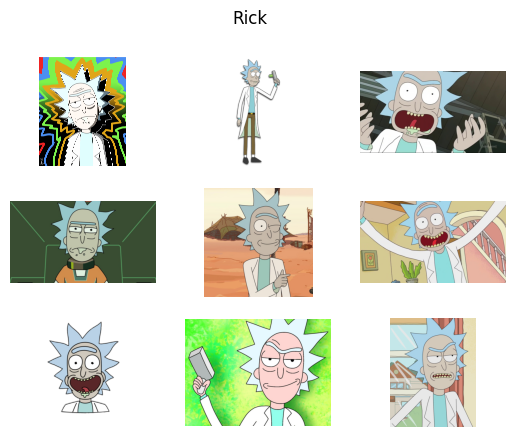

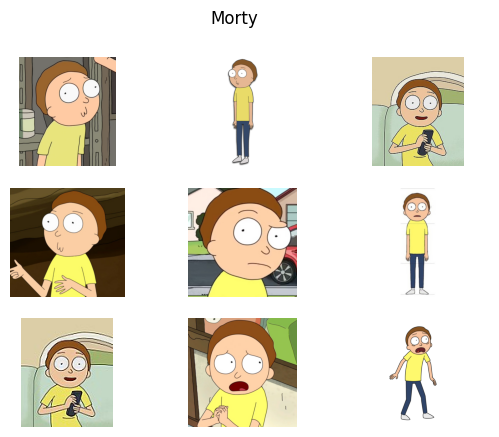

In [18]:
path = 'C:/Users/Dmytrik/Documents/мага 1 курс/іад/RicknMorty/'
categories = ['Rick', 'Morty']
for category in categories:
    fig, _ = plt.subplots(3,3)
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(path+category)[:9]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot(3, 3, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [51]:
paths = []

for k, category in enumerate(categories):
    folder = path + category + '/'
    print("Scanning:", folder)

    for f in os.listdir(folder):
        paths.append([folder + f, k])

X = []
y = []

for img_path, label in paths:

    data = np.fromfile(img_path, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)

    if img is None:
        continue

    img = cv2.resize(img, (55, 32))
    X.append(img)
    y.append(label)


Scanning: C:/Users/Dmytrik/Documents/мага 1 курс/іад/RicknMorty/Rick/
Scanning: C:/Users/Dmytrik/Documents/мага 1 курс/іад/RicknMorty/Morty/


In [59]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

model = Sequential()
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(32, 55, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

import matplotlib.pyplot as plt

# Всі значення після 3 епох
loss = history.history['loss'][3:]
val_loss = history.history.get('val_loss', [])[3:]  # якщо validation_data було
accuracy = history.history['accuracy'][3:]
val_accuracy = history.history.get('val_accuracy', [])[3:]

epochs = range(4, len(history.history['loss'])+1)  # епохи 4,5,...


In [63]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', loss[1])
print('Accuracy:', accuracy[1])

Losses: 0.8467519879341125
Accuracy: 0.9035714268684387


<Figure size 800x500 with 0 Axes>

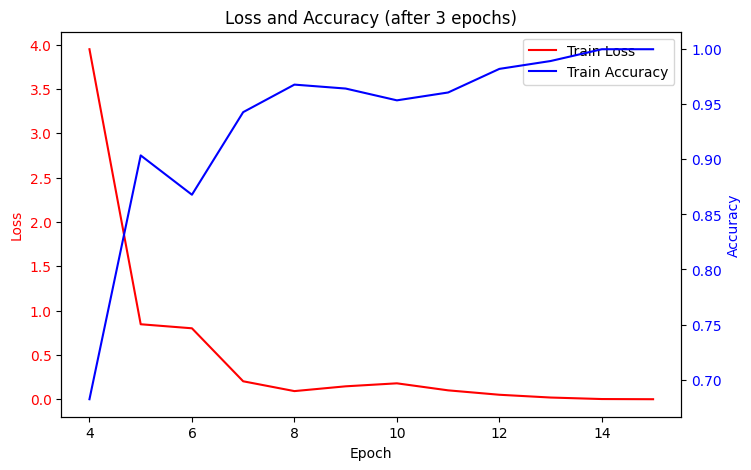

In [65]:
plt.figure(figsize=(8,5))

# Основна вісь — loss
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, loss, 'r-', label='Train Loss')
if val_loss:
    ax1.plot(epochs, val_loss, 'r--', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Додаткова вісь — accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, 'b-', label='Train Accuracy')
if val_accuracy:
    ax2.plot(epochs, val_accuracy, 'b--', label='Val Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Легенда (об’єднана)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Loss and Accuracy (after 3 epochs)')
plt.show()


In [ ]:
########### TASK 3 ############

In [ ]:
# Вирішіть задачу класифікації текстів за допомогою рекурентної нейромережі.
# #https://www.kaggle.com/code/dejavu23/sms-spam-or-ham-beginner/data

In [63]:
dataset = pd.read_csv('spam.csv', encoding='latin-1')
dataset = dataset.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
dataset = dataset.rename(columns={"v1":"label", "v2":"text"})
label = {"ham": 0, "spam": 1}
dataset.label = dataset.label.apply(lambda l:label[l])

In [64]:
def cleaning(value):
    punctuation_cleaning = []
    stopwords_cleaning_string = ''
    
    for i in value:
        if i not in string.punctuation:
            punctuation_cleaning.append(i)
    punctuation_cleaning = "".join(punctuation_cleaning).split()
    
    for j in punctuation_cleaning:
        if j.lower() not in stopwords.words("english"):
            stopwords_cleaning_string += j.lower() + ' '
    
    return stopwords_cleaning_string

dataset['text'] = dataset['text'].apply(cleaning)
dataset.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


In [65]:
X = dataset['text']
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [66]:
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

array = []
for i in X_train:
    array.append(len(i))
maxlen = int(np.ceil(np.mean(array))) # вирівнюємо довжину

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
total_words = len(token.word_index) + 1

In [67]:
model = keras.Sequential()
model.add(Embedding(total_words, 32, input_length= maxlen))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\Dmytrik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8898 - loss: 0.3418
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9789 - loss: 0.1182
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9897 - loss: 0.0684
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9944 - loss: 0.0383
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9975 - loss: 0.0212
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0135
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9996 - loss: 0.0092
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9996 - loss: 0.0068
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9996 - loss: 0.0046
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9998 - loss: 0.0037


In [68]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', results[0])
print('Accuracy:', results[1])

Losses: 0.10677307099103928
Accuracy: 0.9793722033500671


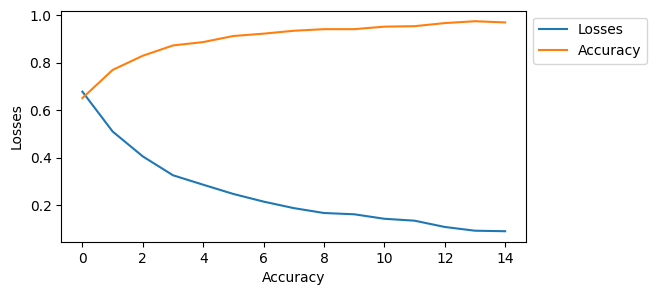

In [70]:
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.ylabel('Losses')
plt.xlabel('Accuracy')
plt.legend(['Losses', 'Accuracy'], bbox_to_anchor = (1, 1))
plt.show()